In [38]:
library(sva)
library(bladderbatch)
data(bladderdata)
pheno <- pData(bladderEset)
edata <- exprs(bladderEset)

Loading required package: mgcv
Warning message:
“package ‘mgcv’ was built under R version 3.6.2”Loading required package: nlme
Warning message:
“package ‘nlme’ was built under R version 3.6.2”This is mgcv 1.8-31. For overview type 'help("mgcv-package")'.
Loading required package: genefilter

Attaching package: ‘genefilter’

The following object is masked from ‘package:MASS’:

    area

Loading required package: BiocParallel
Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, 

In [39]:
model_matrix = model.matrix(~as.factor(cancer), data=pheno)

In [40]:
set.seed(0)

In [79]:
n.sv <- num.sv(edata, model_matrix, vfilter = 2000, method='be')

In [80]:
n.sv

[1] 8

In [42]:
mod <- model_matrix
dat <- edata

In [43]:
H <- mod %*% solve(t(mod) %*% mod) %*% t(mod)

In [44]:
res <- dat - t(H %*% t(dat))

In [50]:
res

,GSM71019.CEL,GSM71020.CEL,GSM71021.CEL,GSM71022.CEL,GSM71023.CEL,GSM71024.CEL,GSM71025.CEL,GSM71026.CEL,GSM71028.CEL,GSM71029.CEL,⋯,GSM71068.CEL,GSM71069.CEL,GSM71070.CEL,GSM71071.CEL,GSM71072.CEL,GSM71073.CEL,GSM71074.CEL,GSM71075.CEL,GSM71076.CEL,GSM71077.CEL
1007_s_at,0.75333949,-0.73378606,-0.58259534,-0.11326116,0.89501087,0.66130275,-0.253796388,-0.626214151,-0.14352089,0.221810391,⋯,0.6361000087,0.741073397,0.6448989137,-0.17114600,-0.25602766,-0.871892948,-0.36448935,0.233583654,0.272811628,-0.22881163
1053_at,0.14462631,-0.13694377,-0.08742582,-0.02113232,-0.01915887,0.04787544,0.051769834,0.020389201,0.07452325,-0.496068159,⋯,0.0946782747,-0.065319947,0.0202586717,-0.12359001,0.13638028,-0.002510911,0.03451536,0.006730426,-0.025475950,0.01901208
117_at,0.01899678,0.33459721,0.13686432,-0.21260584,-0.34857097,-0.53287298,0.085821254,0.517770218,-0.34132137,0.169457018,⋯,-0.2693119765,-0.238201950,-0.1820487014,0.25109312,0.28203773,0.229523368,-0.04765226,-0.331028274,-0.135535460,0.17181244
121_at,-0.13511951,0.40311884,0.50387945,0.21750923,-0.23877248,-1.03398824,0.056845265,0.226527450,-0.53802683,1.507297488,⋯,-0.2772694482,-0.509204744,0.0691845442,-0.09876672,-0.05047330,-0.212171497,0.45918002,-0.336033098,-0.068457133,0.74674192
1255_g_at,-0.20013109,0.29822394,-0.02291891,0.02153479,-0.08929401,-0.24806388,0.234786213,0.005862946,-0.29278451,0.454763300,⋯,-0.1082395274,-0.280258391,0.0467503869,-0.13437508,-0.27798614,-0.056269642,0.17914115,-0.087319394,0.008423704,0.60189340
1294_at,0.30721138,-0.35781779,-0.21954172,-0.45075172,0.42844758,0.47670378,0.001795604,-0.186047104,-0.37880483,0.079116070,⋯,0.2957796039,0.409817324,-0.0707769486,0.10779583,0.08373772,-0.090793287,-0.12665401,-0.133878747,0.099348256,-0.27859613
1316_at,-0.05926951,0.35294104,0.10745714,-0.05545636,-0.23433156,-0.57320307,0.042259818,0.419602500,-0.22267812,0.310159033,⋯,-0.0895454270,-0.210382159,-0.2081150216,0.05679389,0.14271218,-0.085184322,0.16311257,-0.141021561,-0.119903237,0.40198766
1320_at,-0.07042228,0.04617187,0.03045265,0.10339309,-0.08676950,-0.23688063,0.137815002,0.076239799,-0.11145921,-0.049179983,⋯,-0.0536139026,-0.153029383,-0.0950459833,-0.04317162,0.14962903,0.033686777,-0.04010766,-0.091753812,-0.008931226,0.24872388
1405_i_at,-0.19248868,-0.24244729,-0.14333744,0.02940976,0.53144479,0.50079329,0.017174468,-0.500548899,0.67163103,-0.481626121,⋯,-0.9647495164,0.898513084,0.1318115081,-0.62690515,-0.01425592,0.071226155,-0.54322393,-0.151449519,0.460470317,-0.22618655
1431_at,-0.22041356,0.03782499,0.19883912,-0.02537130,-0.18363103,-0.20895885,0.185675820,0.216034810,-0.11544630,0.254352259,⋯,-0.2462943217,-0.071957013,0.0034592940,-0.10126880,0.18787152,-0.148462686,-0.03617172,-0.041438207,-0.016218017,0.22418563


In [48]:
H %*% t(dat)

,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,1431_at,⋯,AFFX-r2-Hs28SrRNA-5_at,AFFX-r2-Hs28SrRNA-M_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
GSM71019.CEL,9.361830,5.200542,6.329028,9.036858,4.167803,7.467972,5.715133,4.925491,5.134586,3.859098,⋯,5.873853,6.249326,12.61401,12.47486,4.344878,3.883440,3.671238,3.440864,3.781592,3.609700
GSM71020.CEL,9.361830,5.200542,6.329028,9.036858,4.167803,7.467972,5.715133,4.925491,5.134586,3.859098,⋯,5.873853,6.249326,12.61401,12.47486,4.344878,3.883440,3.671238,3.440864,3.781592,3.609700
GSM71021.CEL,9.361830,5.200542,6.329028,9.036858,4.167803,7.467972,5.715133,4.925491,5.134586,3.859098,⋯,5.873853,6.249326,12.61401,12.47486,4.344878,3.883440,3.671238,3.440864,3.781592,3.609700
GSM71022.CEL,9.361830,5.200542,6.329028,9.036858,4.167803,7.467972,5.715133,4.925491,5.134586,3.859098,⋯,5.873853,6.249326,12.61401,12.47486,4.344878,3.883440,3.671238,3.440864,3.781592,3.609700
GSM71023.CEL,9.361830,5.200542,6.329028,9.036858,4.167803,7.467972,5.715133,4.925491,5.134586,3.859098,⋯,5.873853,6.249326,12.61401,12.47486,4.344878,3.883440,3.671238,3.440864,3.781592,3.609700
GSM71024.CEL,9.361830,5.200542,6.329028,9.036858,4.167803,7.467972,5.715133,4.925491,5.134586,3.859098,⋯,5.873853,6.249326,12.61401,12.47486,4.344878,3.883440,3.671238,3.440864,3.781592,3.609700
GSM71025.CEL,9.361830,5.200542,6.329028,9.036858,4.167803,7.467972,5.715133,4.925491,5.134586,3.859098,⋯,5.873853,6.249326,12.61401,12.47486,4.344878,3.883440,3.671238,3.440864,3.781592,3.609700
GSM71026.CEL,9.361830,5.200542,6.329028,9.036858,4.167803,7.467972,5.715133,4.925491,5.134586,3.859098,⋯,5.873853,6.249326,12.61401,12.47486,4.344878,3.883440,3.671238,3.440864,3.781592,3.609700
GSM71028.CEL,9.946792,5.521248,6.182800,8.327267,3.883433,7.746619,5.261687,4.741085,5.178871,3.702094,⋯,6.762209,6.429463,12.01878,12.00311,4.153993,3.719683,3.401009,3.374023,3.543761,3.499049
GSM71029.CEL,9.946792,5.521248,6.182800,8.327267,3.883433,7.746619,5.261687,4.741085,5.178871,3.702094,⋯,6.762209,6.429463,12.01878,12.00311,4.153993,3.719683,3.401009,3.374023,3.543761,3.499049


In [51]:
uu <- svd(res)

In [52]:
uu$d

[1] 2.589183e+02 2.156412e+02 1.313073e+02 1.168967e+02 1.068536e+02
 [6] 9.389531e+01 8.735819e+01 8.414707e+01 7.990360e+01 7.647187e+01
[11] 7.199437e+01 7.107224e+01 6.783783e+01 6.592787e+01 6.520252e+01
[16] 6.435978e+01 6.188922e+01 6.008915e+01 5.772281e+01 5.668671e+01
[21] 5.546590e+01 5.488573e+01 5.386218e+01 5.241345e+01 5.108482e+01
[26] 5.057385e+01 4.934157e+01 4.877860e+01 4.813049e+01 4.649719e+01
[31] 4.607862e+01 4.529879e+01 4.487362e+01 4.337273e+01 4.222216e+01
[36] 4.199274e+01 4.132936e+01 4.068876e+01 3.982777e+01 3.895227e+01
[41] 3.893290e+01 3.702144e+01 3.650393e+01 3.596113e+01 3.562519e+01
[46] 3.403271e+01 3.376514e+01 3.314588e+01 3.174375e+01 3.132630e+01
[51] 3.048449e+01 2.973719e+01 2.933646e+01 2.750321e+01 2.432562e-12
[56] 5.665647e-13 2.199691e-13

In [55]:
n <- ncol(dat)
m <- nrow(dat)
ndf <- min(m,n) - ceiling(sum(diag(H)))

In [56]:
dstat <- uu$d[1:ndf]^2/sum(uu$d[1:ndf]^2)

In [57]:
dstat

[1] 0.228749404 0.158671196 0.058831781 0.046627186 0.038959467 0.030083074
 [7] 0.026040041 0.024160864 0.021785482 0.019954362 0.017686077 0.017235918
[13] 0.015702846 0.014831071 0.014506517 0.014133948 0.013069664 0.012320451
[19] 0.011369186 0.010964706 0.010497515 0.010279058 0.009899250 0.009373893
[25] 0.008904678 0.008727431 0.008307308 0.008118824 0.007904513 0.007377137
[31] 0.007244917 0.007001767 0.006870947 0.006419010 0.006082964 0.006017040
[37] 0.005828433 0.005649154 0.005412607 0.005177261 0.005172112 0.004676717
[43] 0.004546882 0.004412666 0.004330606 0.003952097 0.003890196 0.003748810
[49] 0.003438356 0.003348518 0.003170971 0.003017410 0.002936635 0.002581078

In [58]:
res0 <- t(apply(res, 1, sample, replace=FALSE))

In [67]:
sort(res0[1,])

[1] -1.52588798 -1.18330754 -0.96021953 -0.87189295 -0.85076969 -0.73378606
 [7] -0.65914175 -0.62621415 -0.62368545 -0.61848565 -0.58259534 -0.57852029
[13] -0.36448935 -0.32488982 -0.31861154 -0.31009522 -0.25602766 -0.25379639
[19] -0.23392244 -0.22881163 -0.17877216 -0.17114600 -0.15600081 -0.14352089
[25] -0.14340670 -0.11326116 -0.03575381 -0.03492883  0.04774638  0.10745100
[31]  0.18474498  0.21121851  0.22181039  0.23358365  0.23740898  0.24747720
[37]  0.24936606  0.27281163  0.34551607  0.34579945  0.37355786  0.38398238
[43]  0.39097278  0.45512710  0.47091203  0.54661155  0.55822210  0.59898813
[49]  0.63610001  0.64489891  0.66130275  0.68040860  0.69275610  0.74107340
[55]  0.75333949  0.89374247  0.89501087

In [76]:
dstat0 <- matrix(0,nrow=20,ncol=ndf)

In [69]:
res0 <- t(apply(res, 1, sample, replace=FALSE))
res0 <- res0 - t(H %*% t(res0))
uu0 <- svd(res0)

In [77]:
for(i in 1:20){
      res0 <- t(apply(res, 1, sample, replace=FALSE))
      res0 <- res0 - t(H %*% t(res0))
      uu0 <- svd(res0)
      dstat0[i,] <- uu0$d[1:ndf]^2/sum(uu0$d[1:ndf]^2)
    }

In [75]:
sample(0:10)

[1]  1  0  2  5  3  7  4 10  6  8  9

In [86]:
res1 <- apply(res, 1, sample, replace=FALSE)

In [88]:
ncol(res0)

[1] 57

In [83]:
ncol(res1)

[1] 22283

In [85]:
B <- 20
for(i in 1:B){
    
}

1234567891011121314151617181920

In [92]:
psv <- rep(1, n)

In [78]:
dstat0[,1]

[1] 0.02150626 0.02179501 0.02174250 0.02183009 0.02219375 0.02149629
 [7] 0.02171916 0.02157573 0.02179132 0.02174501 0.02154876 0.02178543
[13] 0.02173233 0.02165608 0.02149918 0.02186670 0.02198687 0.02168546
[19] 0.02179214 0.02171006

In [150]:
uu$d

[1] 2.589183e+02 2.156412e+02 1.313073e+02 1.168967e+02 1.068536e+02
 [6] 9.389531e+01 8.735819e+01 8.414707e+01 7.990360e+01 7.647187e+01
[11] 7.199437e+01 7.107224e+01 6.783783e+01 6.592787e+01 6.520252e+01
[16] 6.435978e+01 6.188922e+01 6.008915e+01 5.772281e+01 5.668671e+01
[21] 5.546590e+01 5.488573e+01 5.386218e+01 5.241345e+01 5.108482e+01
[26] 5.057385e+01 4.934157e+01 4.877860e+01 4.813049e+01 4.649719e+01
[31] 4.607862e+01 4.529879e+01 4.487362e+01 4.337273e+01 4.222216e+01
[36] 4.199274e+01 4.132936e+01 4.068876e+01 3.982777e+01 3.895227e+01
[41] 3.893290e+01 3.702144e+01 3.650393e+01 3.596113e+01 3.562519e+01
[46] 3.403271e+01 3.376514e+01 3.314588e+01 3.174375e+01 3.132630e+01
[51] 3.048449e+01 2.973719e+01 2.933646e+01 2.750321e+01 2.432562e-12
[56] 5.665647e-13 2.199691e-13

In [99]:
    for(i in 1:ndf){
      psv[i] <- mean(dstat0[,i] >= dstat[i])
    }

In [74]:
dstat0[,i]

ERROR: Error in eval(expr, envir, enclos): object 'dstat0' not found


In [101]:
    for(i in 2:ndf){
      psv[i] <- max(psv[(i-1)],psv[i]) 
    }
    

In [103]:
nsv <- sum(psv <= 0.10)

In [144]:
ndf

[1] 54

In [105]:
mean(dstat0[,1] >= dstat[1])

[1] 0

In [109]:
dstat0[,5]

[1] 0.02084336 0.02106753 0.02100845 0.02087063 0.02094216 0.02091435
 [7] 0.02105401 0.02099685 0.02090091 0.02077724 0.02089973 0.02104326
[13] 0.02093778 0.02079260 0.02079258 0.02068064 0.02085103 0.02092670
[19] 0.02086700 0.02112795

In [108]:
dstat[5]

[1] 0.03895947

In [116]:
num.sv(edata, model_matrix, method='be', vfilter=2000, seed=0)

[1] 8

In [118]:
res0 <- t(apply(res, 1, sample, replace=FALSE))

In [120]:
ncol(res0)

[1] 57

In [117]:
psv <= 0.10

[1]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE FALSE FALSE
[13] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[25] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[37] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[49] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE

In [135]:
A=matrix(rnorm(100),nc=5)

In [136]:
A

0.57879984,0.71165350,-0.21565521,-0.127174862,1.1117876
-0.40302963,-0.87193803,0.70391149,-0.030479598,-1.8465090
-0.50567078,0.70050501,0.97953577,-1.053363657,0.2099523
1.04429967,-0.19398599,-0.24074647,-1.253727724,-0.3212195
-0.02828343,0.60529131,1.06921289,0.158160934,0.1507218
0.43695690,1.87813493,0.05106044,-0.204763896,0.2173756
1.82475392,1.19384489,-1.84322769,1.579437072,0.5566354
2.71266624,0.42118914,1.15474463,-0.503431538,-0.4526376
0.84766765,-0.66589958,0.60447442,0.005553629,0.8173307
0.01154641,-0.25881603,-1.16353788,-1.417457811,-1.1194579
-1.19075575,-0.79370290,0.73875270,1.391883815,-1.0755625


In [137]:
res0 <- t(apply(A, 1, sample, replace=FALSE))

In [138]:
res0

1.11178762,-0.127174862,0.71165350,0.5787998,-0.21565521
-0.40302963,-0.030479598,-0.87193803,0.7039115,-1.84650902
0.97953577,0.209952328,-0.50567078,0.7005050,-1.05336366
-1.25372772,-0.193985994,-0.24074647,1.0442997,-0.32121950
0.60529131,-0.028283426,1.06921289,0.1581609,0.15072184
1.87813493,0.436956902,-0.20476390,0.2173756,0.05106044
1.82475392,1.579437072,1.19384489,-1.8432277,0.55663536
-0.50343154,2.712666244,1.15474463,-0.4526376,0.42118914
0.81733068,0.005553629,0.84766765,0.6044744,-0.66589958
-1.16353788,0.011546409,-0.25881603,-1.4174578,-1.11945793
-1.07556248,0.738752700,1.39188382,-1.1907557,-0.79370290


In [141]:
dstat

[1] 0.228749404 0.158671196 0.058831781 0.046627186 0.038959467 0.030083074
 [7] 0.026040041 0.024160864 0.021785482 0.019954362 0.017686077 0.017235918
[13] 0.015702846 0.014831071 0.014506517 0.014133948 0.013069664 0.012320451
[19] 0.011369186 0.010964706 0.010497515 0.010279058 0.009899250 0.009373893
[25] 0.008904678 0.008727431 0.008307308 0.008118824 0.007904513 0.007377137
[31] 0.007244917 0.007001767 0.006870947 0.006419010 0.006082964 0.006017040
[37] 0.005828433 0.005649154 0.005412607 0.005177261 0.005172112 0.004676717
[43] 0.004546882 0.004412666 0.004330606 0.003952097 0.003890196 0.003748810
[49] 0.003438356 0.003348518 0.003170971 0.003017410 0.002936635 0.002581078

In [25]:
requireLibs <- function(libs) {
  for(lib in libs){
    if(!require(lib, character.only = T)){
      install.packages(lib, repos="http://cran.ism.ac.jp/")
      require(lib, character.only = T)
    }
  }
}

requireLibs('multcomp')

In [1]:
library(multcomp)

Loading required package: mvtnorm
Loading required package: survival
Warning message:
“package ‘survival’ was built under R version 3.6.2”Loading required package: TH.data
Loading required package: MASS
Warning message:
“package ‘MASS’ was built under R version 3.6.2”
Attaching package: ‘TH.data’

The following object is masked from ‘package:MASS’:

    geyser



In [36]:
tukeyFromFile <- function(path, sep="\t", plot=FALSE) {
    df <- read.csv(path, sep=sep, header=FALSE)
    if (plot) {df_plot <- df}
    df['condition'] <- c(1:length(rownames(df)))
    mergedDf <- df[c(colnames(df)[1], 'condition')]
    for (i in colnames(df)[1:length(colnames(df))-1]) {
        tmp <- df[c(i, "condition")]
        colnames(tmp) <- c(colnames(df)[1], "condition")
        mergedDf <- rbind(mergedDf, tmp)
    }
    colnames(mergedDf) <- c("value", "condition")
    aovData<-data.frame(group=factor(mergedDf$condition), data=mergedDf$value)
    aovResult<-aov(data~group,d=aovData)
    tukeyResult <- glht(aovResult ,linfct=mcp(group="Tukey"))
    print(summary(tukeyResult))
    print(cld(tukeyResult))
    if (plot) {boxplot(t(df_plot))}
}


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = data ~ group, data = aovData)

Linear Hypotheses:
           Estimate Std. Error t value Pr(>|t|)    
2 - 1 == 0  0.07100    0.12024   0.590  0.99041    
3 - 1 == 0 -0.69600    0.12024  -5.788  < 0.001 ***
4 - 1 == 0 -0.50550    0.12024  -4.204  0.00598 ** 
5 - 1 == 0 -0.78575    0.12024  -6.535  < 0.001 ***
6 - 1 == 0 -0.95575    0.12024  -7.948  < 0.001 ***
3 - 2 == 0 -0.76700    0.12024  -6.379  < 0.001 ***
4 - 2 == 0 -0.57650    0.12024  -4.794  0.00171 ** 
5 - 2 == 0 -0.85675    0.12024  -7.125  < 0.001 ***
6 - 2 == 0 -1.02675    0.12024  -8.539  < 0.001 ***
4 - 3 == 0  0.19050    0.12024   1.584  0.61824    
5 - 3 == 0 -0.08975    0.12024  -0.746  0.97302    
6 - 3 == 0 -0.25975    0.12024  -2.160  0.30244    
5 - 4 == 0 -0.28025    0.12024  -2.331  0.23256    
6 - 4 == 0 -0.45025    0.12024  -3.744  0.01581 *  
6 - 5 == 0 -0.17000    0.12024  -1.414  0.71888  

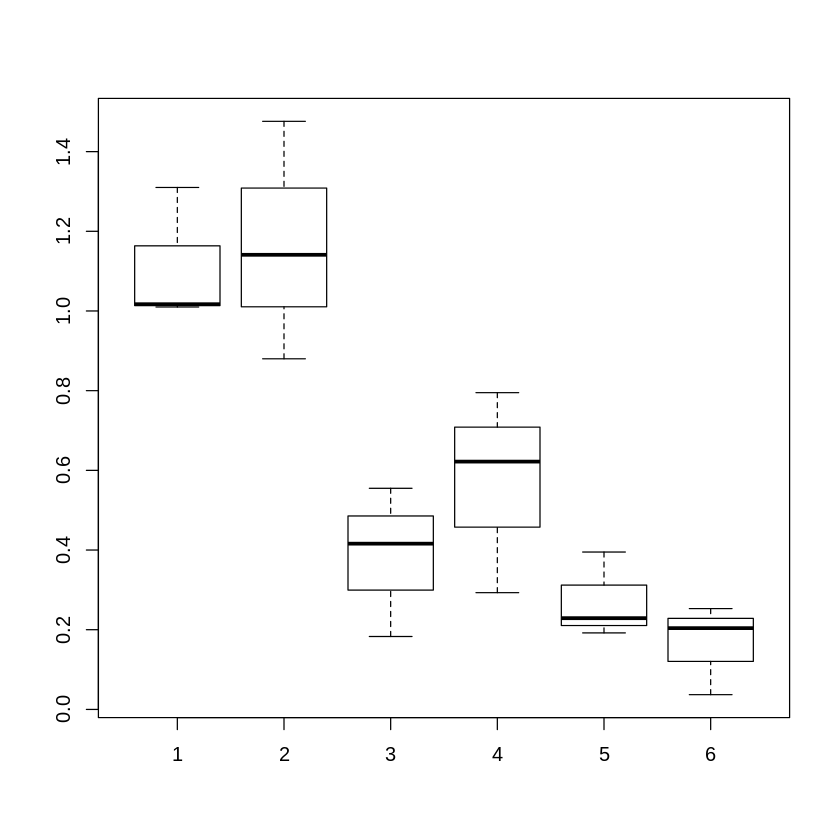

In [37]:
tukeyFromFile("../sabath.csv", sep=",", plot=TRUE)

In [5]:
tukeyFromFile("../sakol.csv", sep=",")


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = data ~ group, data = aovData)

Linear Hypotheses:
           Estimate Std. Error t value Pr(>|t|)    
2 - 1 == 0   0.4101     0.1595   2.572  0.15790    
3 - 1 == 0  -1.0389     0.1595  -6.515  < 0.001 ***
4 - 1 == 0  -0.5167     0.1595  -3.240  0.04603 *  
5 - 1 == 0  -1.1014     0.1595  -6.907  < 0.001 ***
6 - 1 == 0  -1.1604     0.1595  -7.277  < 0.001 ***
3 - 2 == 0  -1.4490     0.1476  -9.815  < 0.001 ***
4 - 2 == 0  -0.9267     0.1476  -6.277  < 0.001 ***
5 - 2 == 0  -1.5115     0.1476 -10.238  < 0.001 ***
6 - 2 == 0  -1.5705     0.1476 -10.638  < 0.001 ***
4 - 3 == 0   0.5222     0.1476   3.538  0.02558 *  
5 - 3 == 0  -0.0625     0.1476  -0.423  0.99794    
6 - 3 == 0  -0.1215     0.1476  -0.823  0.95900    
5 - 4 == 0  -0.5847     0.1476  -3.961  0.01086 *  
6 - 4 == 0  -0.6438     0.1476  -4.361  0.00484 ** 
6 - 5 == 0  -0.0590     0.1476  -0.400  0.99843  

In [13]:
list.files("..", pattern="csv")

[1] "sabath.csv" "sakol.csv"  "tak-1.csv"

In [22]:
tukeyFromFiles <- function(path, pattern=".csv", sep=","){
    files <- list.files(path=path, pattern=pattern, full.names=T)
    for (file in files) {
        notice = paste0("--------------", file, "---------------", sep=" ")
        cat(notice)
        tukeyFromFile(path=file, sep=sep)
    }
}

In [24]:
tukeyFromFiles("..")

--------------../sabath.csv--------------- 
	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = data ~ group, data = aovData)

Linear Hypotheses:
           Estimate Std. Error t value Pr(>|t|)    
2 - 1 == 0  0.07100    0.12024   0.590  0.99041    
3 - 1 == 0 -0.69600    0.12024  -5.788  < 0.001 ***
4 - 1 == 0 -0.50550    0.12024  -4.204  0.00598 ** 
5 - 1 == 0 -0.78575    0.12024  -6.535  < 0.001 ***
6 - 1 == 0 -0.95575    0.12024  -7.948  < 0.001 ***
3 - 2 == 0 -0.76700    0.12024  -6.379  < 0.001 ***
4 - 2 == 0 -0.57650    0.12024  -4.794  0.00169 ** 
5 - 2 == 0 -0.85675    0.12024  -7.125  < 0.001 ***
6 - 2 == 0 -1.02675    0.12024  -8.539  < 0.001 ***
4 - 3 == 0  0.19050    0.12024   1.584  0.61831    
5 - 3 == 0 -0.08975    0.12024  -0.746  0.97303    
6 - 3 == 0 -0.25975    0.12024  -2.160  0.30256    
5 - 4 == 0 -0.28025    0.12024  -2.331  0.23248    
6 - 4 == 0 -0.45025    0.12024  -3.744  0.01584 *  
6 - 5 